# 11wk-1: 추천시스템 (2) – Embedding 레이어, 사용자정의 네트워크,

NN-based 추천시스템, A1-A2

최규빈  
2024-05-13

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/11wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-y4jDwHKvjCIA0zPHvUsYxx&si=X5fHH0vOTVR_-iXZ>

# 2. Imports

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. `torch.nn.Embedding`

## A. 임베딩레이어

`-` 모티브: `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 매번
쓰는건 너무 귀찮지 않어?

In [ ]:
torch.manual_seed(43052)
#x = ['옥순','영숙','하니','옥순','영숙']
x = torch.tensor([0,1,2,0,1])
E = torch.nn.functional.one_hot(x).float() #Linear 태울려면 Float
linr = torch.nn.Linear(3,1,bias=False)
lf = linr(E)
lf

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

`-` 코드를 뜯어보면..

In [ ]:
linr.weight, linr.bias

(Parameter containing:
 tensor([[-0.2002, -0.4890,  0.2081]], requires_grad=True),
 None)

In [ ]:
E @ linr.weight.T #linear를 태우는 것과 동치.

-   ${\boldsymbol x}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow {\bf E}= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$

-   $\text{linr}({\bf E})= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

`-` `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 함께처리해주는
레이어 `torch.nn.Embedding` 존재

In [ ]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1)
ebdd.weight.data = linr.weight.data.T #우리가 알고 있던 가중치로 갱신
ebdd(x)

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

-   우리가 이전에 구현했던 코드 “onehot + linr” 와 “ebdd”는 정확하게
    동일한 동작을 수행함.

`-` 결론: 아래의 두개의 코드는 같다.

``` python
X = torch.tensor([0,1,2,0,1])

## 코드1
linr = torch.nn.Linear(3,1)
linr(torch.nn.functional.one_hot(X))

## 코드2
ebdd = torch.nn.Embedding(3,1)
ebdd(X)
```

`# 의문`: 그냥 원핫인코딩없이 바로 선형변환하면 안되나? (= 꼭
임베딩레이어를 써야하나?)

In [ ]:
x = torch.tensor([0,1,2,0,1])
X = x.reshape(-1,1).float()
x,X

(tensor([0, 1, 2, 0, 1]),
 tensor([[0.],
         [1.],
         [2.],
         [0.],
         [1.]]))

In [ ]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,1)
l1(X)

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<AddmmBackward0>)

In [ ]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1)
ebdd(x)

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], grad_fn=<EmbeddingBackward0>)

결과적으로 0,1,2 를 다른숫자들로 맵핑한건 비슷해보이는데?

`-` 수식의 차이: 비슷해보이지만 계산방식이 조금 다름

In [ ]:
l1.weight, l1.bias

-   $l_1({\bf X}) = \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052 \end{bmatrix}$

`-` 데이터를 읽으며 해석: 사실상 0,1,2에 대한 의미는
“옥순”,“영숙”,“하니” 같은 자료였고, 임베딩의 결과는
“옥순”,“영숙”,“하니”가 가지는 어떠한 특징이었음 (예를들면 매력같은).
데이터를 상상하며 위의 결과를 다시 해석해보자.

**옥순이 가지는 어떠한 특징 (-0.8470 혹은 -0.8178) 을 바꾸고 싶다면?**

-   `ebdd`의 경우: `ebdd.weigth`에 있는 -0.8178 이라는 숫자를 조정하면
    된다. 이 조정은 옥순의 특징만 바꾸며 영숙과 하니의 특징은 바꾸지
    않는다. (개별조정이 쉬움)
-   `linr`의 경우: `linr.weight`에 있는 -0.3467 혹은 `linr.bias`에 있는
    -0.8470 을 조정하면 되는데, 이를 조정하면 옥순의 특징을 바꿈과
    동시에 영숙/하니의 특징까지 같이 바뀌게 된다. (개별조정이 어려움)

**만약에 출연자가 1000명이라면??**

-   `linr`의 경우: 1000명의 특징을 단 2개의 파라메터로 조정해야한다.
    (그리고 한명의 특징을 바꾸면 999명의 특징이 같이 바뀐다, 개별조정은
    애초에 가능하지 않음.)
-   `ebdd`의 경우: 1000개의 특징을 조정할 수 있는 1000개의 파라메터를
    확보할 수 있게 된다.

`-` 결론: ebdd가 더 파라메터 미세조정을 통하여 특징을 학습하기 용이하다.
(독립적으로 특징값을 줄 수 있으니까!)

> 만약에 문자열이 “최우수(A)”, “우수(B)”, “보통(C)”, “미흡(D)”,
> “매우미흡(F)” 이었다면 특징을 뽑아낼때 linr 가 더 적절했겠죠?

## B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

영식(IN)  영철(IN)  영호(IS)  광수(IS)  상철(EN)  영수(EN)  규빈(ES)  다호(ES)
옥순(IN)     NaN    4.02    3.45    3.42    0.84    1.12    0.43    0.49
영자(IN)    3.93    3.99    3.63    3.43    0.98    0.96    0.52     NaN
정숙(IS)    3.52    3.42    4.05    4.06    0.39     NaN    0.93    0.99
영숙(IS)    3.43    3.57     NaN    3.95    0.56    0.52    0.89    0.89
순자(EN)    1.12     NaN    0.59    0.43    4.01    4.16    3.52    3.38
현숙(EN)    0.94    1.05    0.32    0.45    4.02    3.78     NaN    3.54
서연(ES)    0.51    0.56    0.88    0.89    3.50    3.64    4.04    4.10
보람(ES)    0.48    0.51    1.03     NaN    3.52    4.00    3.82     NaN
하니(I)     4.85    4.82     NaN    4.98    4.53    4.39    4.45    4.52

In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

임베딩레이어를 활용하여 MF-based 추천시스템을 설계하라.

(풀이)

In [ ]:
torch.manual_seed(43052)
ebdd1 = torch.nn.Embedding(9,2)
b1 = torch.nn.Embedding(9,1)
ebdd2 = torch.nn.Embedding(8,2)
b2 = torch.nn.Embedding(8,1)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(ebdd1.parameters())+list(b1.parameters())+list(ebdd2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1)
#--#
for epoc in range(100):
    # 1
    W_feature = ebdd1(X1)
    W_bias = b1(X1)
    M_feature = ebdd2(X2)
    M_bias = b2(X2)
    score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score)*5
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis=1)[::4]

tensor([[4.1083, 4.0200],
        [0.9388, 1.1200],
        [4.0483, 3.9900],
        [0.9707, 0.9600],
        [4.2264, 4.0500],
        [0.9518, 0.9900],
        [0.5124, 0.5600],
        [1.1198, 1.1200],
        [4.0588, 4.1600],
        [1.0596, 1.0500],
        [3.9666, 3.7800],
        [0.9472, 0.8800],
        [3.9194, 4.0400],
        [1.0346, 1.0300],
        [4.8851, 4.8500],
        [4.5387, 4.3900]], grad_fn=<SliceBackward0>)

# 4. 사용자정의 네트워크

## A. 사용자정의 네트워크 사용법

`# 예비학습1`: `net(x)`와 사실 `net.forward(x)`는 같다.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [ ]:
X = torch.randn(5,1)
X

tensor([[ 0.3837],
        [ 0.7194],
        [-0.2655],
        [-1.2488],
        [ 0.5538]])

In [ ]:
net(X)

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

In [ ]:
net.forward(X) #

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

관찰: net(X)와 net.foward(X) 의 결과가 같다... => net.foward(X) 의 결과를 갖다가 net(X)에서 출력을 하는것이다.

그래서 `net.forward`를 재정의하면 `net(x)`의 기능을 재정의 할 수 있다.

In [ ]:
net.forward = lambda x: '메롱'

-   `lambda x: '메롱'` 은 입력이 x 출력이 ’메롱’인 함수를 의미 (즉
    입력값에 상관없이 항상 ’메롱’을 출력하는 함수)
-   `net.forward = lambda x:1` 이라고 새롭게 선언하였므로 앞으론
    `net.forward(x)`, `net(x)` 도 입력값에 상관없이 항상 ’메롱’을
    출력하게 될것임

In [ ]:
net.forward(X)

'메롱'

In [ ]:
net(X)

'메롱'

`#`

`# 예비학습2`: `torch.nn.Module`을 상속받아서 네트워크를 만들면 (=
“`class XXX(torch.nn.Module):`” 와 같은 방식으로 클래스를 선언하면)
약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

(예시1)

In [ ]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False) #self. 뭐시기 변수를 만들고
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x))) #여기서 x를 뭐시기 변수에 대입.
        return yhat

이제

``` python
net = Mynet1()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

(예시2)

In [ ]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False) #선언 : 순서 알빠없음
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x))) #실제 네트워크 정의 : 순서 알빠 있음.
        return yhat

이제

``` python
net = Mynet2()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.RuLU(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

***클래스에 대한 이해가 부족한 학생을 위한 암기방법***

**step1:** 아래와 코드를 복사하여 틀을 만든다. (이건 무조건 고정임, XXXX
자리는 원하는 이름을 넣는다)

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의
        
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의
        
        ## 정의 끝
        return yhat
```

-   `forward`의 입력: `X`는 `net(X)`에 사용하는 `X`임
-   `forward`의 출력: `yhat`은 `net.forward(X)` 함수의 리턴값임
-   사실, `X`/`yhat`은 다른 변수로 써도 무방하나 (예를들면
    `input`/`output` 이라든지, `netin`/`netout` 이라든지) 설명의 편의상
    `X`와 `yhat`을 고정한다.

**step2:** `def __init__(self):`에 yhat을 구하기 위해 필요한 재료를
레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx` 와 같은 식으로
정의한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의
        
        ## 정의 끝
        return yhat
```

**step3:** `def forward:`에 “X –\> yhat” 으로 가는 과정을 묘사한 코드를
작성하고 yhat을 리턴하도록 한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의
        u = self.xxx1(X)
        v = self.xxx2(u)
        yhat = self.xxx3(v)
        ## 정의 끝
        return yhat
```

`#`

`# 실습`: 사용자정의 네트워크를 사용하여 아래의 자료를 학습해보자.

In [ ]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

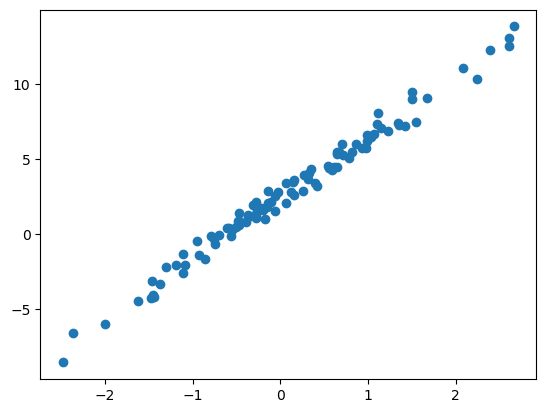

In [ ]:
plt.plot(x,y,'o')

(풀이)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레어어를 정의
        self.linr = torch.nn.Linear(1,1)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의
        yhat = self.linr(X)
        ## 정의 끝
        return yhat

In [ ]:
net = Net()

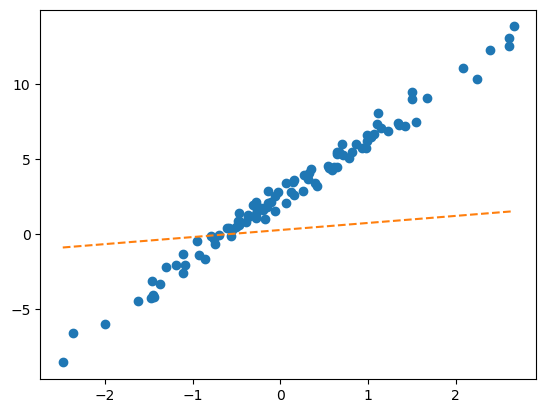

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--') # 최초의 직선

In [ ]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.1)
for epoc in range(30):
    # 1
    yhat = net(x)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

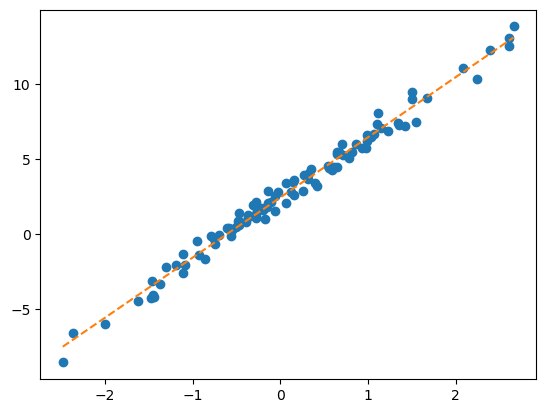

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

`#`

## B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

영식(IN)  영철(IN)  영호(IS)  광수(IS)  상철(EN)  영수(EN)  규빈(ES)  다호(ES)
옥순(IN)     NaN    4.02    3.45    3.42    0.84    1.12    0.43    0.49
영자(IN)    3.93    3.99    3.63    3.43    0.98    0.96    0.52     NaN
정숙(IS)    3.52    3.42    4.05    4.06    0.39     NaN    0.93    0.99
영숙(IS)    3.43    3.57     NaN    3.95    0.56    0.52    0.89    0.89
순자(EN)    1.12     NaN    0.59    0.43    4.01    4.16    3.52    3.38
현숙(EN)    0.94    1.05    0.32    0.45    4.02    3.78     NaN    3.54
서연(ES)    0.51    0.56    0.88    0.89    3.50    3.64    4.04    4.10
보람(ES)    0.48    0.51    1.03     NaN    3.52    4.00    3.82     NaN
하니(I)     4.85    4.82     NaN    4.98    4.53    4.39    4.45    4.52

In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

사용자정의 네트워크를 이용하여 MF-based 추천시스템을 설계하라.

(풀이1) – `net(X1,X2)`

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X1,X2): #X1도 받고,, X2도 받아야 하는데... -> 받으면 됨!!
        W_feature = self.ebdd1(X1)
        W_bias = self.b1(X1)
        M_feature = self.ebdd2(X2)
        M_bias = self.b2(X2)
        score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias
        yhat = sig(score) * 5
        return yhat

In [ ]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--#
for epoc in range(100):
    # 1
    yhat = net(X1,X2)  #net.forwad(X1,X2) 와 exactly same
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
torch.concat([yhat.data,y],axis=1)[::5]

In [ ]:
list(net.parameters()) #네트워크의 파라미터들을 리스트에 넣으면 한번에 볼 수 있다.. 너무 편리함.

[Parameter containing:
 tensor([[-1.1573, -1.0290],
         [-1.1707, -1.0023],
         [-2.8631, -0.0077],
         [-2.5007, -0.2065],
         [ 1.1621,  1.2269],
         [ 1.6099,  1.0624],
         [-0.0045,  2.0496],
         [ 1.6851,  1.1801],
         [-1.2459,  0.0969]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0198, -0.6746],
         [ 0.0196, -0.8006],
         [-0.3367, -0.3176],
         [-0.5189, -0.2170],
         [ 0.9036,  0.7954],
         [ 0.9258,  0.7827],
         [ 0.6213,  1.2522],
         [ 0.4934,  1.3402]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1883],
         [-0.1110],
         [ 0.0385],
         [-0.0607],
         [-1.3460],
         [-1.4742],
         [-1.2517],
         [-1.7592],
         [ 2.6079]], requires_grad=True),
 Parameter containing:
 tensor([[0.7128],
         [0.8074],
         [0.3623],
         [0.0642],
         [0.4615],
         [0.6166],
         [0.1937],
         [0.0112]], requires_grad=Tr

(풀이2) – `net(X)`

In [ ]:
X = torch.stack([X1,X2],axis=1) #우리는 네트워크에 X1, X2가 들어가는 것이 탐탁치 않다.. X 하나로 넣고 싶다.
X[:5]

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5]])

In [ ]:
X[:,0], X[:,1]

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8]),
 tensor([1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 6, 7, 0, 1, 3,
         4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5,
         6, 7, 0, 1, 2, 4, 5, 6, 0, 1, 3, 4, 5, 6, 7]))

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X): #X만 입력하면
        X1,X2 = X[:,0],X[:,1] #언패킹해서 두개로 쪼갬
        W_feature = self.ebdd1(X1)
        W_bias = self.b1(X1)
        M_feature = self.ebdd2(X2)
        M_bias = self.b2(X2)
        score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias
        yhat = sig(score) * 5
        return yhat

In [ ]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--#
for epoc in range(100):
    # 1
    yhat = net(X)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
torch.concat([yhat.data,y],axis=1)[::5] #핵습이 꽤 잘되는군.

tensor([[4.0992, 4.0200],
        [0.5983, 0.4300],
        [3.5031, 3.4300],
        [3.3560, 3.4200],
        [0.9673, 0.9900],
        [0.7109, 0.5200],
        [0.4792, 0.4300],
        [0.8460, 0.9400],
        [3.9426, 3.7800],
        [0.9220, 0.8900],
        [0.6960, 0.4800],
        [3.9795, 3.8200],
        [4.5683, 4.3900]])

# 5. NN-based 추천시스템

## A. NN-based 방식

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

영식(IN)  영철(IN)  영호(IS)  광수(IS)  상철(EN)  영수(EN)  규빈(ES)  다호(ES)
옥순(IN)     NaN    4.02    3.45    3.42    0.84    1.12    0.43    0.49
영자(IN)    3.93    3.99    3.63    3.43    0.98    0.96    0.52     NaN
정숙(IS)    3.52    3.42    4.05    4.06    0.39     NaN    0.93    0.99
영숙(IS)    3.43    3.57     NaN    3.95    0.56    0.52    0.89    0.89
순자(EN)    1.12     NaN    0.59    0.43    4.01    4.16    3.52    3.38
현숙(EN)    0.94    1.05    0.32    0.45    4.02    3.78     NaN    3.54
서연(ES)    0.51    0.56    0.88    0.89    3.50    3.64    4.04    4.10
보람(ES)    0.48    0.51    1.03     NaN    3.52    4.00    3.82     NaN
하니(I)     4.85    4.82     NaN    4.98    4.53    4.39    4.45    4.52

In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

NN-based 추천시스템을 설계하라.

(풀이1) – 실패

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,1),
            torch.nn.Sigmoid()
        )
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1) #(n,2)
        M_feature = self.ebdd2(X2) #(n,2)
        W_bias = self.b1(X1) #(n,1)
        M_bias = self.b2(X2) #(n,1)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1) #(n,6)의 새로운 입력이라고 생각하자.
        yhat = self.mlp(Z) * 5
        return yhat

In [ ]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--#
for epoc in range(1000):
    # 1
    yhat = net(X1,X2)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[2.1564, 4.0200],
        [1.6906, 0.4300],
        [2.6465, 3.4300],
        [2.7761, 3.4200],
        [2.5817, 0.9900],
        [2.3108, 0.5200],
        [2.6378, 0.4300],
        [1.7229, 0.9400],
        [2.3890, 3.7800],
        [2.4100, 0.8900],
        [1.9783, 0.4800],
        [2.0172, 3.8200],
        [4.7445, 4.3900]])

-   못하겠네?

(풀이2) – 에라 모르겠다 깊은신경망..

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,1),
            torch.nn.Sigmoid()
        )
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        M_feature = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1)
        yhat = self.mlp(Z) * 5
        return yhat

In [ ]:
torch.manual_seed(43052)
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--#
for epoc in range(1000):
    # 1
    yhat = net(X1,X2)
    # 2
    loss = loss_fn(yhat,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
torch.concat([yhat.data,y],axis=1)[::5]

-   잘 맞추긴했는데 불안함

In [ ]:
df_view

(옥순-영식), (영자-다호), (하니-영호) 를 예측해보자.

In [ ]:
X1

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
XX1 = torch.tensor([0,1,8])
XX2 = torch.tensor([1,7,2])

In [ ]:
net(XX1,XX2)

그럴싸함.. (오버피팅 아닌듯)

## B. NCF (He et al. 2017)

![](https://github.com/guebin/DL2024/blob/main/posts/NCF.png?raw=true)

# A1. 자잘한 용어 정리 ($\star$)

## A. 지도학습

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다.

1.  데이터는 $(X,y)$의 형태로 정리되어 있다.

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는
    것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|  $X$ = 설명변수 = 독립변수   | $y$ = 반응변수 = 종속변수  |     비고     |     순서     |           예시           |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|            이미지            |          카테고리          | 합성곱신경망 |   상관없음   |  개/고양이 이미지 구분   |
|         유저,아이템          |            평점            |  추천시스템  |   상관없음   |    넷플릭스 영화추천     |
|     과거~오늘까지의주가      |          내일주가          |  순환신경망  | 순서상관있음 |         주가예측         |
| 처음 $m$개의 단어(혹은 문장) | 이후 1개의 단어(혹은 문장) |  순환신경망  | 순서상관있음 |     챗봇, 텍스트생성     |
| 처음 $m$개의 단어(혹은 문장) |          카테고리          |  순환신경망  | 순서상관있음 | 영화리뷰 텍스트 감정분류 |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를
supervised learning 이라한다.

## B. 모델이란?

> 모델이란 단어는 제 발작버튼이었어요..

`-` 통계학에서 모델은 y와 x의 관계를 의미하며 오차항의 설계를 포함하는
개념이다. 이는 통계학이 “데이터 = 정보 + 오차”의 관점을 유지하기
때문이다. 따라서 통계학에서 모델링이란

$$y_i = net(x_i) + \epsilon_i$$

에서 (1) 적절한 함수 $net$를 선택하는 일 (2) 적절한 오차항 $\epsilon_i$
을 설계하는일 모두를 포함한다.

`-` 딥러닝 혹은 머신러닝에서 모델은 단순히

$$y_i \approx net(x_i)$$

를 의미하는 경우가 많다. 즉 “model=net”라고 생각해도 무방하다. 이 경우
“모델링”이란 단순히 적절한 $net$을 설계하는 것만을 의미할 경우가 많다.

`-` 그래서 생긴일

-   통계학교재 특: 분류문제와 회귀문제를 엄밀하게 구분하지 않는다. 사실
    오차항만 다를뿐이지 크게보면 같은 회귀모형이라는 관점이다. 그래서
    일반화선형모형(GLM)이라는 용어를 쓴다.
-   머신러닝/딥러닝교재 특: 회귀문제와 분류문제를 구분해서 설명한다.
    (표도 만듦) 이는 오차항에 대한 기술을 모호하게 하여 생기는 현상이다.

## C. 학습이란?

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
“규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘
    찾는 것이다. (이 경우 “함수를 추정한다”라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “모델” 혹은 “모형”을 찾는 것이다. 즉 $y\approx model(X)$가 되도록
    만드는 $model$을 잘 찾는 것이다. (이 경우 “모형을 학습시킨다”라고
    표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는
    어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록
    만드는 $net$을 잘 찾는 것이다. (이 경우 “네트워크를 학습시킨다”라고
    표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여
$\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는
$f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## D. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에
따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

## E. 다양한 코드들

`-` 파이썬 코드..

``` python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
learner.learn() # fastai 에서 "학습"을 의미하는 과정
learner.fine_tune(1) # fastai 에서 "부분학습"을 의미하는 과정
learner.predict(cat1) # fastai 에서 "예측"을 의미하는 과정
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정
```

`-` R 코드..

``` r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```

# A2. 참고자료들

`-` 케라스/텐서플로우: <https://guebin.github.io/STBDA2022/>

`-` 상속:
<https://guebin.github.io/PP2023/posts/03_Class/2023-06-12-15wk-1.html>

`-` sklearn/autogluon: <https://guebin.github.io/MP2023/>

`-` 리눅스관련: <https://guebin.github.io/DSTBX2024/> – 자료 부실함..
강의영상 없는것 많음..

`-` 클래스기본: <https://guebin.github.io/PP2023/> – `10wk-2` ~ `15wk-1`

He, Xiangnan, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, and
Tat-Seng Chua. 2017. “Neural Collaborative Filtering.” In *Proceedings
of the 26th International Conference on World Wide Web*, 173–82.